# Nuclei detection

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scout import io
from scout import utils
from scout import plot
from scout.detection import nucleus_probability
from scout.detection import detect_nuclei_parallel

In [3]:
%matplotlib notebook

## Select working directory for current organoid

In [88]:
parent_dir = '/media/jswaney/SSD EVO 860/organoid_phenotyping'
# folder_name = '20190430_11_36_09_AA-4.30.19-org1_488LP12p5_561LP120_642LP50'
folder_name = '20190625_14_48_13_AA_ef24-zika1_488LP15_561LP140_642LP50'
working_dir = os.path.join(parent_dir, folder_name)
os.listdir(working_dir)

['Ex1_rescaled',
 'sox2.zarr',
 'tbr1.zarr',
 'Ex0_rescaled',
 'syto.zarr',
 'Ex2_rescaled']

## Set parameters on test images

In [89]:
syto_path = 'syto.zarr'

syto_zarr = io.open(os.path.join(working_dir, syto_path))
syto_zarr.shape

(900, 5359, 5359)

In [104]:
# extract test patch
shape = np.array((256, 256, 256))
start = np.array((256, 1024, 2048))

stop = start + shape
syto_test = utils.extract_box(syto_zarr, start, stop)
syto_test.shape

(256, 256, 256)

<IPython.core.display.Javascript object>


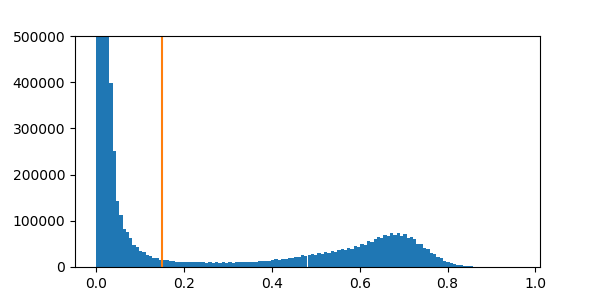

In [105]:
# Set threshold for nuclei detection
min_intensity = 0.15

ymax = 500000
plt.figure(figsize=(6, 3))
plt.hist(syto_test.ravel(), bins=128)
plt.plot([min_intensity, min_intensity], [0, ymax])
plt.ylim([0, ymax])
plt.show()

<IPython.core.display.Javascript object>


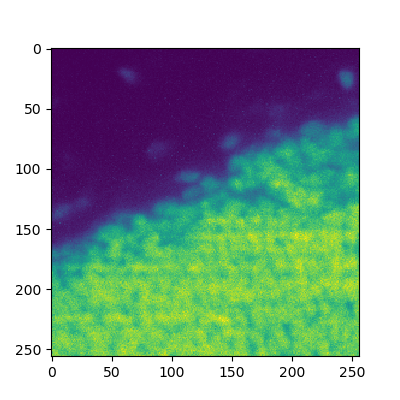

In [106]:
# test image
plt.figure(figsize=(4, 4))
plt.imshow(syto_test[32])
plt.show()

In [107]:
sigma = (1.0, 3.0, 3.0)
steepness = 450
offset = -0.0005
I0 = 1
stdev = 0.15

prob = nucleus_probability(syto_test, sigma, steepness, offset, I0, stdev)

<IPython.core.display.Javascript object>


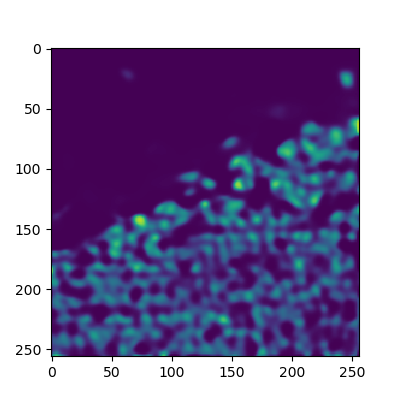

In [108]:
# Probability map
plt.figure(figsize=(4, 4))
plt.imshow(prob[32], clim=[0, 1])
plt.show()

## Detect nuclei in whole organoid

In [109]:
prob_path = 'nuclei_probability.zarr'
chunks = (64, 64, 64)
min_dist = 2
prob_thresh = 0.2
overlap = 8
nb_workers = 1  # One worker is GPU

prob_output = io.new_zarr(os.path.join(working_dir, prob_path), 
                          syto_zarr.shape, 
                          syto_zarr.chunks,
                          np.float32)

# GPU runtime error fixed by installing pytorch-nightly build
results = detect_nuclei_parallel(syto_zarr, 
                                 sigma=sigma, 
                                 min_intensity=min_intensity,
                                 steepness=steepness, 
                                 offset=offset,
                                 I0=I0,
                                 stdev=stdev,
                                 prob_thresh=prob_thresh,
                                 min_dist=min_dist,
                                 chunks=chunks,
                                 overlap=overlap,
                                 nb_workers=nb_workers,
                                 prob_output=prob_output)
centers_list = [r for r in results if r is not None]

100%|██████████| 105840/105840 [1:03:58<00:00, 27.57it/s] 


In [110]:
centers = np.vstack(centers_list)  # Make coordinates array (Nx3)
centers.shape

(2213769, 3)

## Check the results

<IPython.core.display.Javascript object>


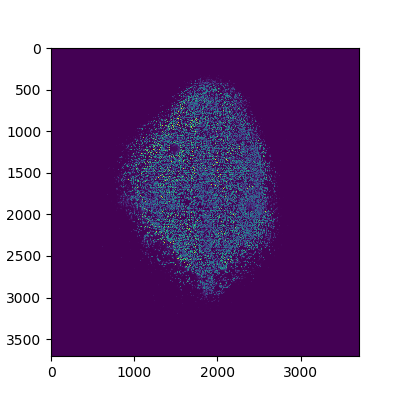

In [15]:
# check that the probability map was saved properly
plt.figure(figsize=(4, 4))
plt.imshow(prob_output[300], clim=[0, 1])
plt.show()

<IPython.core.display.Javascript object>


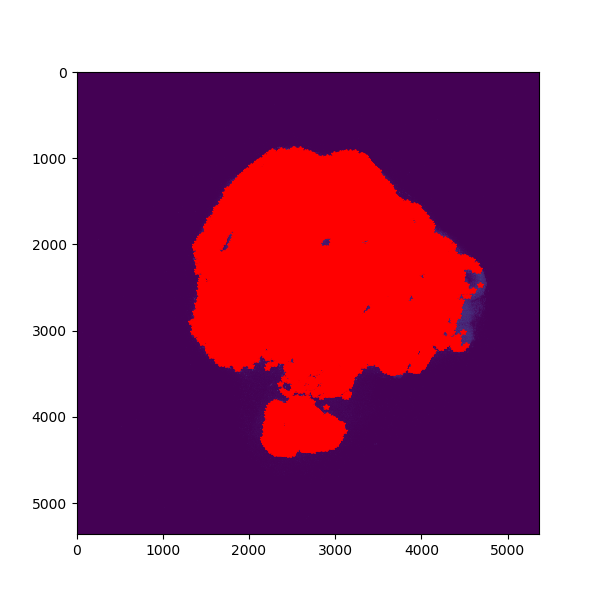

In [111]:
# Show detections overlay
plt.figure(figsize=(6, 6))
plot.zprojection(syto_zarr, centers, zlim=[200, 205])

## Save the results

In [112]:
centers_path = 'centroids.npy'

np.save(os.path.join(working_dir, centers_path), centers)

In [113]:
from scout.utils import read_voxel_size

In [115]:
voxel_size = utils.read_voxel_size(os.path.join(working_dir, 'voxel_size.csv'))
centroids_um = centers * np.asarray(voxel_size)

In [116]:
centers_um_path = 'centroids_um.npy'

np.save(os.path.join(working_dir, centers_um_path), centroids_um)

# Save an ROI for manual annotation

Do this in ImageJ...